# Exemple sur le modèle jouet Campbell

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os
import gpflow

In [29]:
%reload_ext autoreload
%autoreload 2

import model_class

On récupère les entrées

In [30]:
hs_list = np.arange(1, 3.1, 0.5)
msl_list = np.arange(0, 1.1, 0.1)
print(hs_list)
x_train=[]
for hs in hs_list:
    for msl in msl_list:
        x_train.append([hs,msl])
x_train=np.array(x_train)
print("taille de x_train:",x_train.shape)

[1.  1.5 2.  2.5 3. ]
taille de x_train: (55, 2)


In [32]:
base_folder = "data_malo_GP"

# On récupère le nombre de cellules terrestres
cell_info = np.fromfile(os.path.join(base_folder, "scattered_land_data.bin"),
                        dtype=">f8").reshape(-1, 5)
n_cells = cell_info.shape[0]

y_train_H_max = []
y_train_H_moyenne = []

for hs in hs_list:
    for msl in msl_list:

        folder_name = f"run_msl_{msl:.1f}_hs_{hs:.1f}"
        file_path = os.path.join(base_folder, folder_name, "scattered_map_final.bin")

        if not os.path.exists(file_path):
            print("⚠️ Fichier manquant :", file_path)
            Hmax = np.full(n_cells, np.nan)
            Hmoyenne = np.full(n_cells, np.nan)
        else:
            # Lecture correcte du binaire (big-endian float64)
            data = np.fromfile(file_path, dtype=">f8").reshape(-1, 3)

            # Colonnes : [ID_global, Hmax_T, Hmean_T]
            Hmax = data[:, 1]   # Hauteur max
            Hmoyenne = data[:, 2]  # Hauteur moyenne

        y_train_H_max.append(Hmax)
        y_train_H_moyenne.append(Hmoyenne)
y_train_Hmax = np.array(y_train_H_max)
y_train_H_moyenne = np.array(y_train_H_moyenne)

print("Taille de y_train_Hmax :", y_train_Hmax.shape)
print("Taille de y_train_H_moyenne :", y_train_H_moyenne.shape)

Taille de y_train_Hmax : (55, 488290)
Taille de y_train_H_moyenne : (55, 488290)


In [34]:
for y in [y_train_Hmax,y_train_H_moyenne]:
    print("type:",y.dtype)
    print("Présence de NaN:",np.isnan(y).any())
    print("Présence d'infini:",np.isinf(y).any())
    print("min =", np.nanmin(y))
    print("max =", np.nanmax(y))
    print("mean =", np.nanmean(y))
    print("std =", np.nanstd(y))

type: float64
Présence de NaN: False
Présence d'infini: False
min = 0.0
max = 12.982820152414803
mean = 0.42061597141293916
std = 0.827666663401021
type: float64
Présence de NaN: False
Présence d'infini: False
min = 0.0
max = 10.610930827498573
mean = 0.2073012196349514
std = 0.730124241144225


In [37]:
y_train = y_train_Hmax #y_train_H_moyenne

In [40]:
n_pc = 5  # On choisit arbitrairement le nombre de composantes principales (d'après la thèse, 5 semble un bon compromis)
theta = 3 # On choisit arbitrairement la valeur de theta 
sigma = 1 # et de sigma
param = [theta, sigma]

kernel = gpflow.kernels.SquaredExponential(lengthscales=param[0], variance=param[1]**2) + gpflow.kernels.White(variance=1e-6)


--- Entraînement du modèle GP pour la composante principale  1 ---
Modèle GP créé pour la composante principale  1 . Optimisation des hyperparamètres...
Optimisation terminée.
Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [493.53574]         │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.9630980734670048  │
├─────────────────────────┼─────────

W0000 00:00:1764866081.864299   11527 cholesky_op_gpu.cu.cc:205] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.


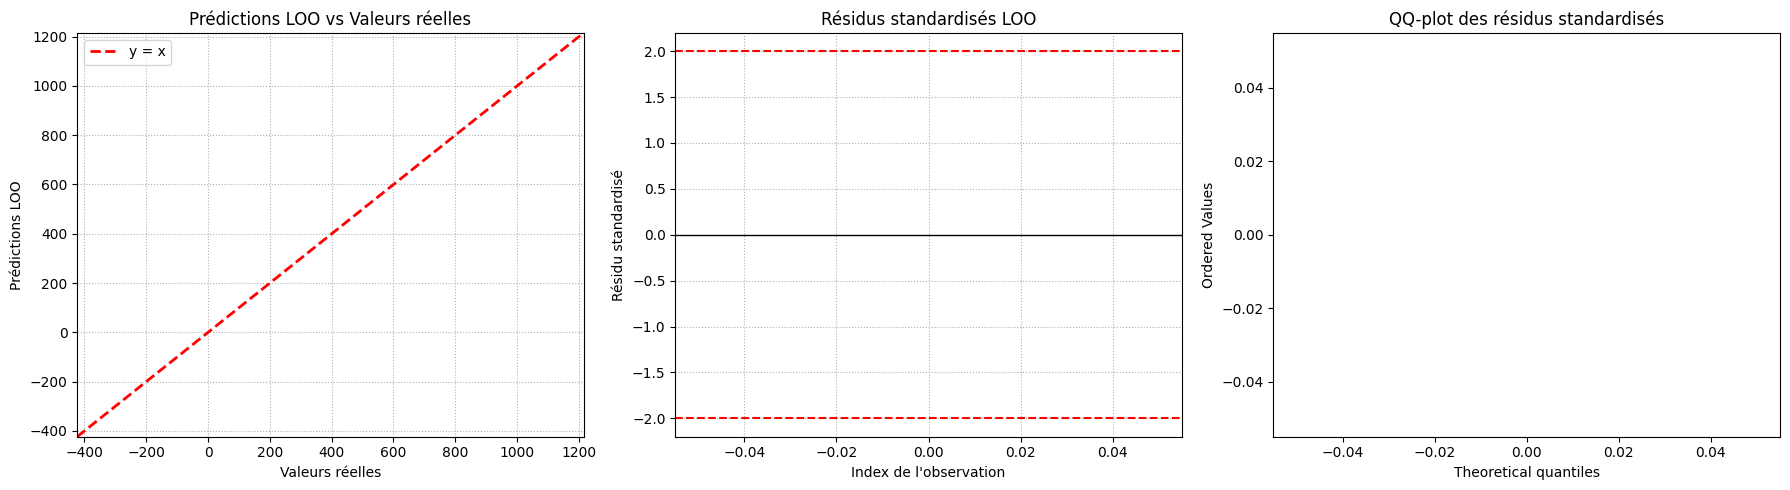


--- Entraînement du modèle GP pour la composante principale  2 ---
Modèle GP créé pour la composante principale  2 . Optimisation des hyperparamètres...
Optimisation terminée.
Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [-100.11204]        │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.7352565665926658  │
├─────────────────────────┼─────────

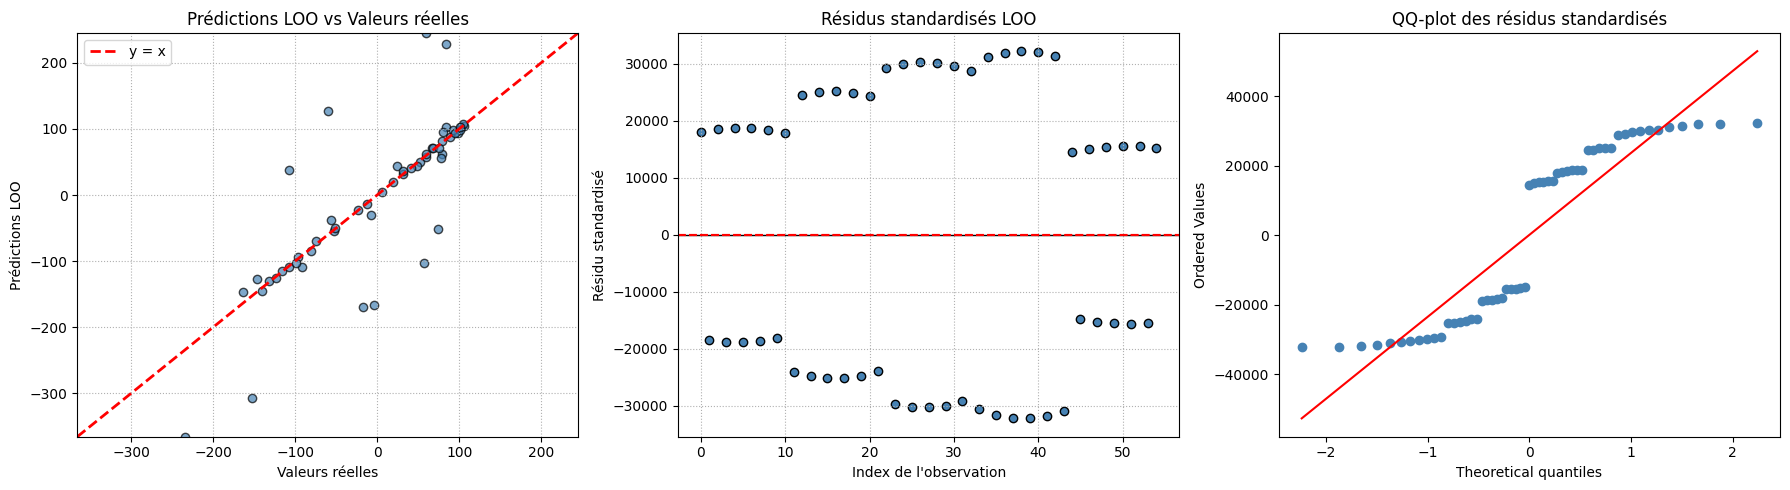


--- Entraînement du modèle GP pour la composante principale  3 ---
Modèle GP créé pour la composante principale  3 . Optimisation des hyperparamètres...
Optimisation terminée.
Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [-0.00157168]         │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.0006399237722187631 │
├───────────────────────

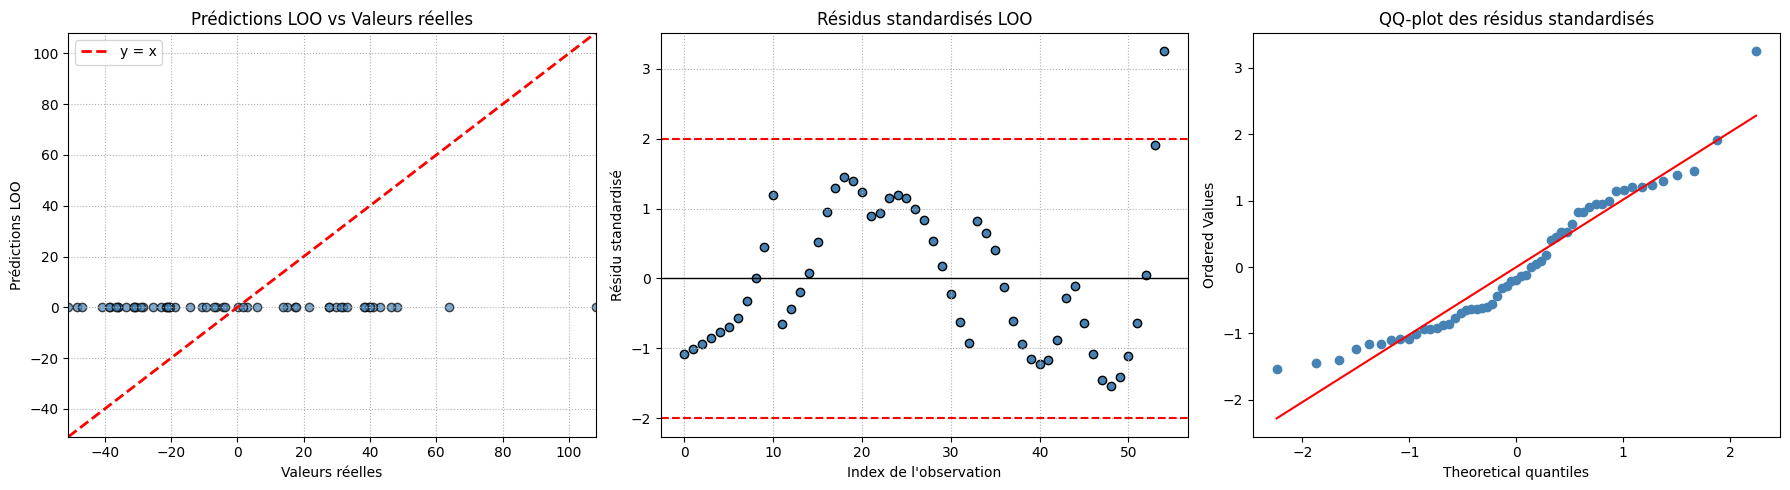


--- Entraînement du modèle GP pour la composante principale  4 ---
Modèle GP créé pour la composante principale  4 . Optimisation des hyperparamètres...
Optimisation terminée.
Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [-0.00161737]         │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 9.920948841919795e-07 │
├───────────────────────

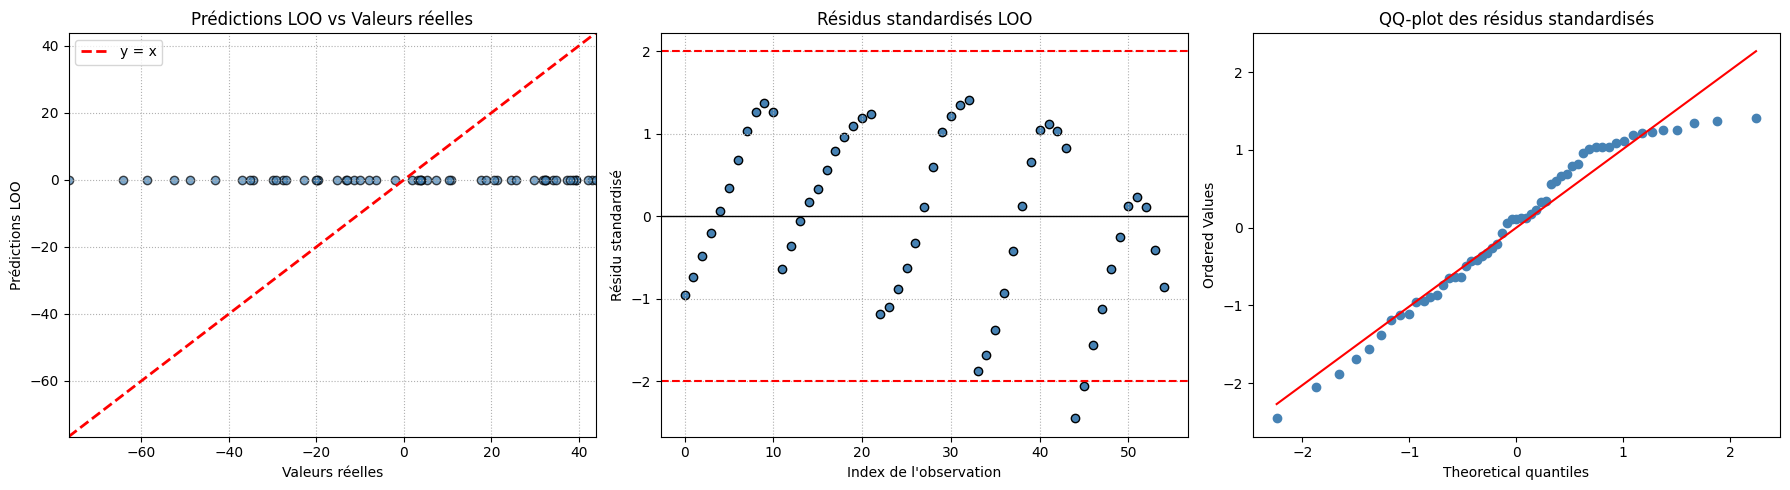


--- Entraînement du modèle GP pour la composante principale  5 ---
Modèle GP créé pour la composante principale  5 . Optimisation des hyperparamètres...
Optimisation terminée.
Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [8.86335089e-07]      │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.0003203995803599243 │
├───────────────────────

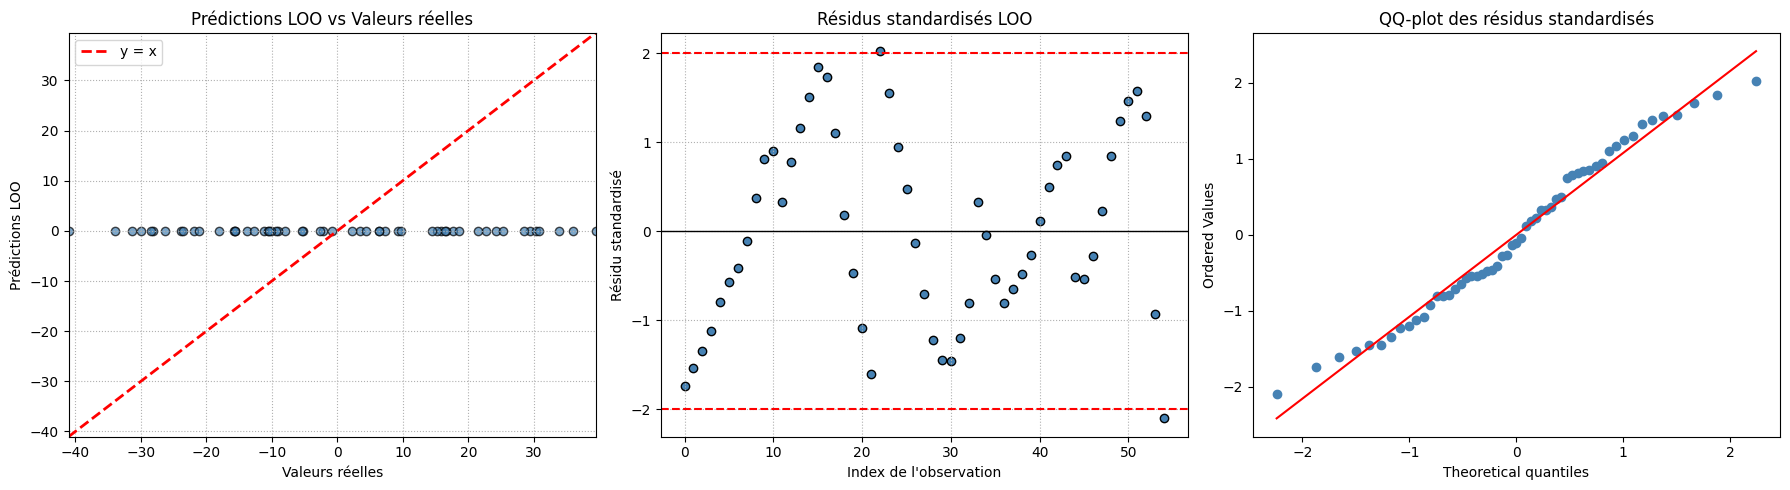

--- Analyse en Composantes Principales ---
Variance expliquée par les 5 premières composantes : [0.92841928 0.04785526 0.0068079  0.00585052 0.00253236]
Variance globale expliquée : 0.9914653239194513
Taille du jeu d'entrainement transformé par ACP : (55, 5)


In [ ]:
# ACP
ACP = model_class.ACP_classique(n_pc,[theta,sigma])
ACP.train(x_train,y_train,kernel_fn=kernel,verbose=True)

Bon bah ça à l'air de fonctionner, maintenant on peut voir ce que ca donne

In [44]:
Y_train_reconstruct_ACP = ACP.predict(x_train)  # On prédit sur les données d'entraînement pour vérifier la reconstruction

mse_ACP = np.mean((y_train - Y_train_reconstruct_ACP)**2)
print("MSE ACP sur données d'entraînement :", mse_ACP)

Prédiction en cours...
MSE ACP sur données d'entraînement : 0.0029398797322501484


In [45]:
hs_list_test = np.arange(1, 3.1, 0.1)
msl_list_test = np.arange(0, 1.1, 0.05)
print(hs_list_test)
x_test=[]
for hs in hs_list_test:
    for msl in msl_list_test:
        x_test.append([hs,msl])
x_test=np.array(x_test)
print("taille de x_test:",x_test.shape)


[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7
 2.8 2.9 3. ]
taille de x_test: (462, 2)


In [46]:
Y_test_reconstruct_ACP = ACP.predict(x_test)

Prédiction en cours...


In [47]:
print(Y_test_reconstruct_ACP.shape)

(462, 488290)
